<a href="https://colab.research.google.com/github/istiak9999/Malicious-url-classification-using-deep-learning-sequential-model/blob/main/malcious_url_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu

In [ ]:
!nvidia-smi

In [ ]:
# install additional library
!pip install tldextract -q

# import library
import numpy as np
import pandas as pd
import re
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import seaborn as sns
import gc
import random
import os
import pickle
import tensorflow as tf
from tensorflow.python.util import deprecation
from urllib.parse import urlparse
import tldextract

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, backend, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

# set random seed
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

# other setup
%config InlineBackend.figure_format = 'retina'
pd.set_option('max_colwidth', 50)
pio.templates.default = "presentation"
pd.options.plotting.backend = "plotly"
deprecation._PRINT_DEPRECATION_WARNINGS = False

     |████████████████████████████████| 93 kB 2.3 MB/s 


In [ ]:
# load data
data = pd.read_csv('/content/drive/MyDrive/Machine Learning Dataset/Malicious url researchpaper data/malicious_phish _kaggle.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
data.shape

(651191, 2)

In [ ]:
data.rename(columns={'type':'label'},inplace=True)

In [ ]:
data.columns

Index(['url', 'label'], dtype='object')

In [ ]:
data.describe()

,url,label
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [ ]:
data['label'].unique()

array(['phishing', 'benign', 'defacement', 'malware'], dtype=object)

In [ ]:
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=0)

In [ ]:
def parsed_url(url):
    # extract subdomain, domain, and domain suffix from url
    # if item == '', fill with '<empty>'
    subdomain, domain, domain_suffix = ('<empty>' if extracted == '' else extracted for extracted in tldextract.extract(url))   
    
    return [subdomain, domain, domain_suffix]

def extract_url(data):
    # parsed url
    extract_url_data = [parsed_url(url) for url in data['url']]
    extract_url_data = pd.DataFrame(extract_url_data, columns=['subdomain', 'domain', 'domain_suffix'])
    
    # concat extracted feature with main data
    data = data.reset_index(drop=True)
    data = pd.concat([data, extract_url_data], axis=1)
    
    return data

def get_frequent_group(data, n_group):
    # get the most frequent
    data = data.value_counts().reset_index(name='values')
    
    # scale log base 10
    data['values'] = np.log10(data['values'])
    
    # calculate total values
    # x_column (subdomain / domain / domain_suffix)
    x_column = data.columns[1]
    data['total_values'] = data[x_column].map(data.groupby(x_column)['values'].sum().to_dict())
    
    # get n_group data order by highest values
    data_group = data.sort_values('total_values', ascending=False).iloc[:, 1].unique()[:n_group]
    data = data[data.iloc[:, 1].isin(data_group)]
    data = data.sort_values('total_values', ascending=False)
    
    return data
def get_frequent_group(data, n_group):
    # get the most frequent
    data = data.value_counts().reset_index(name='values')
    
    # scale log base 10
    data['values'] = np.log10(data['values'])
    
    # calculate total values
    # x_column (subdomain / domain / domain_suffix)
    x_column = data.columns[1]
    data['total_values'] = data[x_column].map(data.groupby(x_column)['values'].sum().to_dict())
    
    # get n_group data order by highest values
    data_group = data.sort_values('total_values', ascending=False).iloc[:, 1].unique()[:n_group]
    data = data[data.iloc[:, 1].isin(data_group)]
    data = data.sort_values('total_values', ascending=False)
    
    return data
def plot(data, n_group, title):
    data = get_frequent_group(data, n_group)
    fig = px.bar(data, x=data.columns[1], y='values', color='label')
    fig.update_layout(title=title)
    fig.show()



In [ ]:
# extract url
data = extract_url(data)
train_data = extract_url(train_data)
val_data = extract_url(val_data)

In [ ]:
tokenizer = Tokenizer(filters='', char_level=True, lower=False, oov_token=1)

# fit only on training data
tokenizer.fit_on_texts(train_data['url'])
n_char = len(tokenizer.word_index.keys())

train_seq = tokenizer.texts_to_sequences(train_data['url'])
val_seq = tokenizer.texts_to_sequences(val_data['url'])

print('Before tokenization: ')
print(train_data.iloc[0]['url'])
print('\nAfter tokenization: ')
print(train_seq[0])

Before tokenization: 
oreilly.com/catalog/9780596007072/

After tokenization: 
[3, 11, 2, 7, 14, 14, 27, 12, 9, 3, 13, 6, 9, 5, 4, 5, 14, 3, 21, 6, 36, 38, 31, 24, 34, 36, 39, 24, 24, 38, 24, 38, 25, 6]


In [ ]:
sequence_length = np.array([len(i) for i in train_seq])
sequence_length = np.percentile(sequence_length, 99).astype(int)
print(f'Before padding: \n {train_seq[0]}')
train_seq = pad_sequences(train_seq, padding='post', maxlen=sequence_length)
val_seq = pad_sequences(val_seq, padding='post', maxlen=sequence_length)
print(f'After padding: \n {train_seq[0]}')

Before padding: 
 [3, 11, 2, 7, 14, 14, 27, 12, 9, 3, 13, 6, 9, 5, 4, 5, 14, 3, 21, 6, 36, 38, 31, 24, 34, 36, 39, 24, 24, 38, 24, 38, 25, 6]
After padding: 
 [ 3 11  2  7 14 14 27 12  9  3 13  6  9  5  4  5 14  3 21  6 36 38 31 24
 34 36 39 24 24 38 24 38 25  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
sequence_length

234

In [ ]:
unique_value = {}
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
for feature in ['subdomain', 'domain', 'domain_suffix']:
  size=len(train_data[feature].unique())
  unique_value[feature]=size
  train_data[feature]=encoder.fit_transform(train_data[feature])
  val_data[feature]=encoder.fit_transform(val_data[feature])

In [ ]:
train_data.head()

,url,label,subdomain,domain,domain_suffix
0,oreilly.com/catalog/9780596007072/,phishing,1143,86384,150
1,content.usatoday.com/community/tags/topic.aspx...,benign,7000,119828,150
2,e.pa.ypal.help.sec.us-login-cgi.bin.resolution...,benign,8954,41600,150
3,news.stanford.edu/news/2006/february22/med-ill...,benign,19843,107488,240
4,skate-works.com/oakland_university_?b=1,benign,1143,104372,150


In [ ]:
unique_value

{'subdomain': 35756, 'domain': 129162, 'domain_suffix': 830}

In [ ]:
unique_value = {}
for feature in ['subdomain', 'domain', 'domain_suffix']:
    # get unique value
    label_index = {label: index for index, label in enumerate(train_data[feature].unique())}
    
    # add unknown label in last index
    label_index['<unknown>'] = list(label_index.values())[-1] + 1
    
    # count unique value
    unique_value[feature] = label_index['<unknown>']
    
    # encode
    train_data.loc[:, feature] = [label_index[val] if val in label_index else label_index['<unknown>'] for val in train_data.loc[:, feature]]
    val_data.loc[:, feature] = [label_index[val] if val in label_index else label_index['<unknown>'] for val in val_data.loc[:, feature]]
    
train_data.head()

,url,label,subdomain,domain,domain_suffix
0,oreilly.com/catalog/9780596007072/,phishing,0,0,0
1,content.usatoday.com/community/tags/topic.aspx...,benign,1,1,0
2,e.pa.ypal.help.sec.us-login-cgi.bin.resolution...,benign,2,2,0
3,news.stanford.edu/news/2006/february22/med-ill...,benign,3,3,1
4,skate-works.com/oakland_university_?b=1,benign,0,4,0


In [ ]:
for data in [train_data, val_data]:
    data.loc[:, 'label'] = [0 if i == 'benign' for i in data.loc[:, 'label']]
    
train_data.head()

SyntaxError: ignored

In [ ]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
for data in [train_data, val_data]:
  data['label']=encoder.fit_transform(data['label'])


In [ ]:
train_data.head()

,url,label,subdomain,domain,domain_suffix
0,oreilly.com/catalog/9780596007072/,3,0,0,0
1,content.usatoday.com/community/tags/topic.aspx...,0,1,1,0
2,e.pa.ypal.help.sec.us-login-cgi.bin.resolution...,0,2,2,0
3,news.stanford.edu/news/2006/february22/med-ill...,0,3,3,1
4,skate-works.com/oakland_university_?b=1,0,0,4,0


In [ ]:
train_data['label'].unique()

array([3, 0, 1, 2])

In [ ]:
# create train data
train_x = [train_seq]
train_y = train_data['label'].values
val_x=[val_seq]
val_y=val_data['label'].values

In [ ]:
train_x

[array([[ 3, 11,  2, ...,  0,  0,  0],
        [ 9,  3,  8, ...,  0,  0,  0],
        [ 2, 12, 15, ...,  0,  0,  0],
        ...,
        [18,  4,  4, ...,  0,  0,  0],
        [18,  4,  4, ...,  0,  0,  0],
        [ 8,  5,  4, ...,  0,  0,  0]], dtype=int32)]

In [ ]:
from keras.layers import LSTM
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Add, BatchNormalization, Activation, Dropout
from tensorflow import keras
from tensorflow.keras import layers,Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
unique_value,sequence_length

({'subdomain': 35756, 'domain': 129162, 'domain_suffix': 830}, 234)

In [ ]:
sum(unique_value.values())

165748

In [ ]:
model = keras.Sequential([
    layers.Embedding(165755,128,input_length=sequence_length),
    layers.Conv1D(128,7,padding='same',activation='elu'),
    layers.MaxPool1D(pool_size=2),
    layers.Bidirectional(LSTM(128,return_sequences=True)),
    layers.Flatten(),
    layers.Dense(128,activation='tanh'),
    layers.Dropout(0.5),
    layers.Dense(1,activation='sigmoid')

])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 234, 128)          21216640  
                                                                 
 conv1d (Conv1D)             (None, 234, 128)          114816    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 117, 128)         0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 117, 256)         263168    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 29952)             0         
                                                                 
 dense (Dense)               (None, 128)               3

In [ ]:
# model training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.Precision(), metrics.Recall()])
early_stopping = [EarlyStopping(monitor='val_precision', patience=12, restore_best_weights=True, mode='max')]
history = model.fit(train_x, train_y, batch_size=64, epochs=40, verbose=1, validation_data=(val_x,val_y), shuffle=True, callbacks=early_stopping)

Epoch 1/40
8140/8140 [==============================] - 251s 29ms/step - loss: -139.2322 - precision: 0.8241 - recall: 0.9612 - val_loss: -283.8837 - val_precision: 0.9346 - val_recall: 0.9674
Epoch 2/40
8140/8140 [==============================] - 223s 27ms/step - loss: -427.5075 - precision: 0.8858 - recall: 0.9752 - val_loss: -572.6830 - val_precision: 0.8998 - val_recall: 0.9802
Epoch 3/40
8140/8140 [==============================] - 225s 28ms/step - loss: -726.0051 - precision: 0.8980 - recall: 0.9790 - val_loss: -872.0037 - val_precision: 0.9191 - val_recall: 0.9810
Epoch 4/40
8140/8140 [==============================] - 223s 27ms/step - loss: -1023.7253 - precision: 0.9060 - recall: 0.9807 - val_loss: -1172.4567 - val_precision: 0.9331 - val_recall: 0.9788
Epoch 5/40
8140/8140 [==============================] - 220s 27ms/step - loss: -1323.1600 - precision: 0.9105 - recall: 0.9810 - val_loss: -1463.8330 - val_precision: 0.9602 - val_recall: 0.9768
Epoch 6/40
8140/8140 [=========

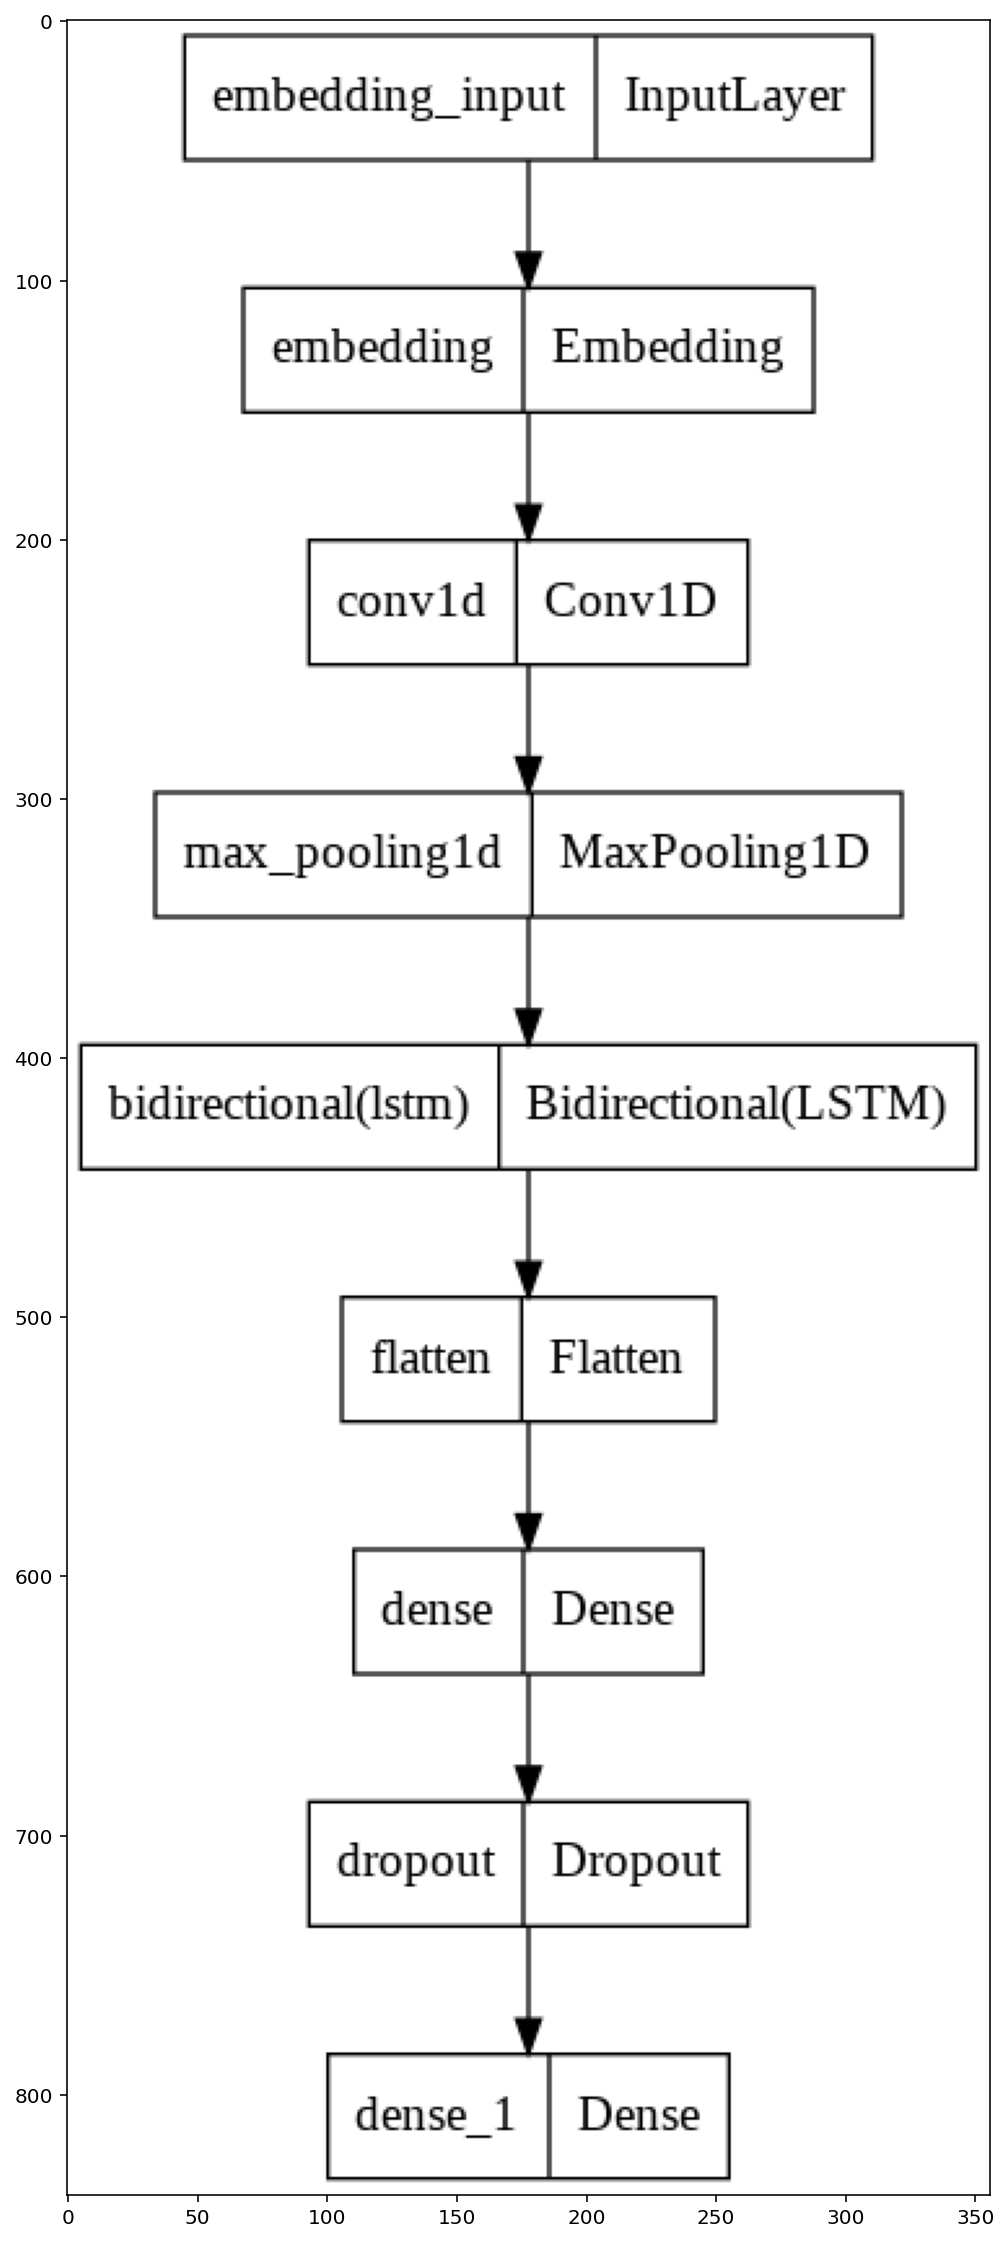

In [ ]:
# show model architecture
plot_model(model, to_file='model.png')
model_image = mpimg.imread('model.png')
plt.figure(figsize=(10, 20))
plt.imshow(model_image)
plt.show()

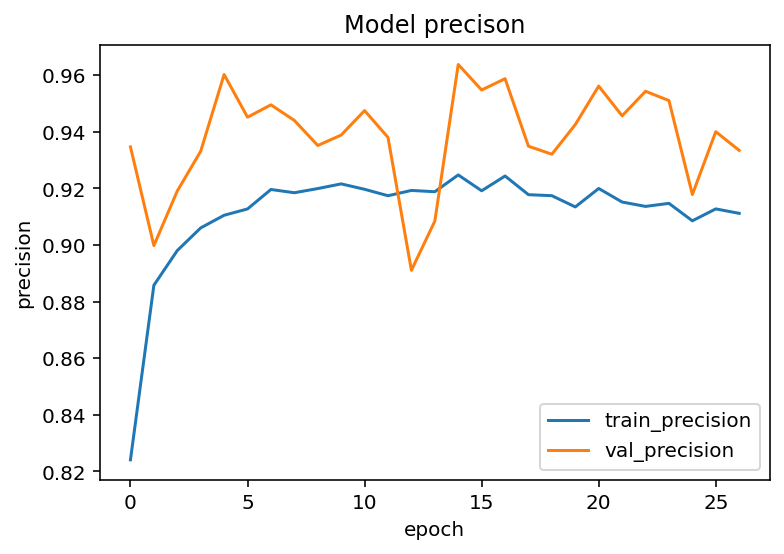

In [ ]:
# plot the training artifacts
import matplotlib.pyplot as plt
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precison')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train_precision','val_precision'], loc = 'lower right')
plt.show()

In [ ]:
fig = make_subplots(3, 1, subplot_titles=('loss', 'precision', 'recall'))

for index, key in enumerate(['loss', 'precision', 'recall']):
    # train score
    fig.add_trace(go.Scatter(
        x=list(range(len(history.history[key]))),
        y=history.history[key],
        mode='lines+markers',
        name=key
    ), index + 1, 1)
    
    # val score
    fig.add_trace(go.Scatter(
        x=list(range(len(history.history[f'val_{key}']))),
        y=history.history[f'val_{key}'],
        mode='lines+markers',
        name=f'val {key}'
    ), index + 1, 1)

fig.show()

In [ ]:
fig = make_subplots(3, 1, subplot_titles=('loss', 'precision', 'recall'))

val_x = [val_seq]
val_y = val_data['label'].values

val_pred = model.predict(val_x)
val_pred = np.where(val_pred[:, 0] >= 0.5, 1, 0)

2628/2628 [==============================] - 14s 5ms/step


In [ ]:
print(f'Validation Data:\n{val_data.label.value_counts()}')
print(f'\n\nConfusion Matrix:\n{confusion_matrix(val_y, val_pred)}')
print(f'\n\nClassification Report:\n{classification_report(val_y, val_pred)}')


Validation Data:
0    68964
1    15129
Name: label, dtype: int64


Confusion Matrix:
[[68473   491]
 [ 2152 12977]]


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     68964
           1       0.96      0.86      0.91     15129

    accuracy                           0.97     84093
   macro avg       0.97      0.93      0.94     84093
weighted avg       0.97      0.97      0.97     84093



In [ ]:
cr=classification_report(val_y, val_pred)

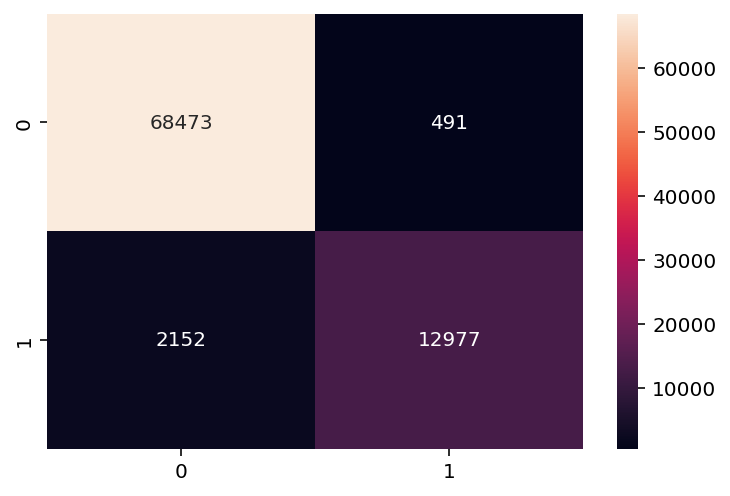

In [ ]:
import seaborn as sns
cm= confusion_matrix(val_y, val_pred)
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title, y=1.25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, number_of_classes=2, title='Classification report ', cmap='RdYlGn'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')
    
    #drop initial lines
    lines = lines[2:]

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[: number_of_classes]:
        t = list(filter(None, line.strip().split('  ')))
        if len(t) < 4: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)


    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score','Support']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 10
    figure_height = len(class_names) + 3
    correct_orientation = True
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    plt.show()



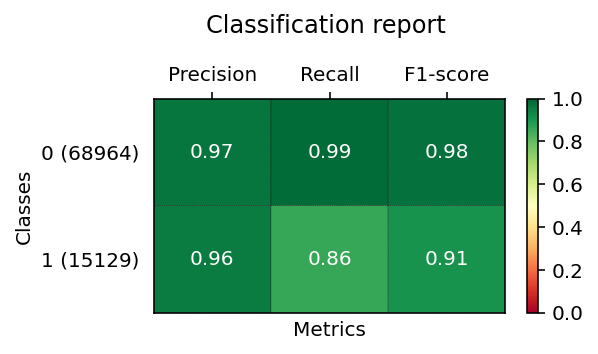

In [ ]:
plot_classification_report(cr)